In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch.optim as optim
from model import AlexNet
import os
import json
import time
#import cv2

In [2]:
#device : GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((224, 224)),  # cannot 224, must (224, 224)
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

In [4]:
#data_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # get data root path
data_root = os.getcwd()
image_path = data_root + "/data/"  # flower data set path
train_dataset = datasets.ImageFolder(root=image_path + "/train",
                                     transform=data_transform["train"])
train_num = len(train_dataset)

In [5]:
cd_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in cd_list.items())
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

In [6]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=0)

validate_dataset = datasets.ImageFolder(root=image_path + "/val",
                                        transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=0)

test_data_iter = iter(validate_loader)
test_image, test_label = test_data_iter.next()
print(test_image[0].size(),type(test_image[0]))
print(test_label[0],test_label[0].item(),type(test_label[0]))

torch.Size([3, 224, 224]) <class 'torch.Tensor'>
tensor(7) 7 <class 'torch.Tensor'>


In [7]:
net = AlexNet(num_classes=9, init_weights=False)

net.to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.0002)

save_path = './AlexNet.pth'

best_acc = 0.0

In [8]:
# a dictionary used to store all loss and accuracy
stats = {"train_loss":[],"train_acc":[],"val_acc":[],"val_loss":[]}

for epoch in range(40):
    # train
    net.train()
    running_loss = 0.0
    correct = 0
    t1 = time.perf_counter()
    for step, data in enumerate(train_loader, start=0):
        images, labels = data
        #print(labels.shape)
        optimizer.zero_grad()
        outputs = net(images.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        # get the training accuracy
        _, predicted = outputs.max(1)
        correct += (predicted == labels.to(device)).sum().item()

        # print train process
        rate = (step + 1) / len(train_loader)
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")
    print()
    print(time.perf_counter()-t1)

    #calculate the training accuracy
    train_accurate = correct / len(train_loader)

    # validate
    net.eval()  
    acc = 0.0  # accumulate accurate number / epoch
    val_loss = 0.0

    with torch.no_grad():
        for v_step,val_data in enumerate(validate_loader):
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += (predict_y == val_labels.to(device)).sum().item()
            val_loss += loss_function(outputs, val_labels.to(device)).item()
        val_accurate = acc / val_num
        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
        print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f' %
              (epoch + 1, running_loss / step, val_accurate))
    
    # save the status

    stats["train_loss"].append(running_loss / step)
    stats["train_acc"].append(train_accurate)
    stats["val_acc"].append(val_accurate)
    stats["val_loss"].append(val_loss / v_step)

print('Finished Training')

/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train loss: 100%[**************************************************->]1.599
130.377352962
[epoch 1] train_loss: 1.927  test_accuracy: 0.287
train loss: 100%[**************************************************->]0.949
123.96181333500002
[epoch 2] train_loss: 1.623  test_accuracy: 0.356
train loss: 100%[**************************************************->]1.696
147.097728222
[epoch 3] train_loss: 1.454  test_accuracy: 0.430
train loss: 100%[**************************************************->]1.924
173.21907639699998
[epoch 4] train_loss: 1.317  test_accuracy: 0.450
train loss: 100%[**************************************************->]1.926
153.30521376800004
[epoch 5] train_loss: 1.294  test_accuracy: 0.548
train loss: 100%[**************************************************->]1.101
155.61542334599994
[epoch 6] train_loss: 1.208  test_accuracy: 0.559
train loss: 100%[**************************************************->]1.158
147.41282099199998
[epoch 7] train_loss: 1.133  test_accuracy: 0

In [14]:
stats["train_acc"]

[1.6948529411764706,
 2.7095588235294117,
 3.4411764705882355,
 3.761029411764706,
 4.0036764705882355,
 4.268382352941177,
 4.477941176470588,
 4.761029411764706,
 4.790441176470588,
 4.772058823529412,
 4.981617647058823,
 5.158088235294118,
 5.283088235294118,
 5.319852941176471,
 5.375,
 5.474264705882353,
 5.4963235294117645,
 5.632352941176471,
 5.713235294117647,
 5.661764705882353,
 5.610294117647059,
 5.786764705882353,
 5.963235294117647,
 5.834558823529412,
 5.963235294117647,
 5.8713235294117645,
 6.047794117647059,
 6.022058823529412,
 6.0661764705882355,
 6.022058823529412,
 6.110294117647059,
 6.044117647058823,
 6.0625,
 6.117647058823529,
 6.216911764705882,
 6.3786764705882355,
 6.268382352941177,
 6.264705882352941,
 6.323529411764706,
 6.426470588235294]

In [17]:
def plot_figure(name, stats):
  fig_1 = plt.figure(figsize=(8, 4))
  ax_1 = fig_1.add_subplot(111)
  for k in ['train_loss', 'val_loss']:
    item = stats[k]
    ax_1.plot(np.arange(1, len(item)+1), item, label='{}_{}'.format(name, k))

  ax_1.legend(loc=0)
  ax_1.set_ylabel('Loss')
  ax_1.set_xlabel('Epoch number')

  # Plot the change in the validation and training set accuracy over training.
  fig_2 = plt.figure(figsize=(8, 4))
  ax_2 = fig_2.add_subplot(111)

  for k in ['train_acc', 'val_acc']:
    item = stats[k]
    if k == 'train_acc':
      ax_2.plot(np.arange(1, len(item)+1), [i/8 for i in item], label='{}_{}'.format(name, k))
    else:
      ax_2.plot(np.arange(1, len(item)+1), item, label='{}_{}'.format(name, k))
    


  ax_2.legend(loc=0)
  ax_2.set_ylabel('Accuracy')
  ax_2.set_xlabel('Epoch number')

  return fig_1, fig_2

(<Figure size 576x288 with 1 Axes>, <Figure size 576x288 with 1 Axes>)

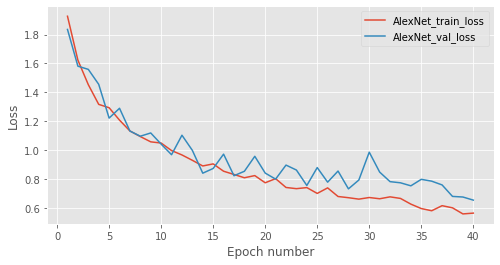

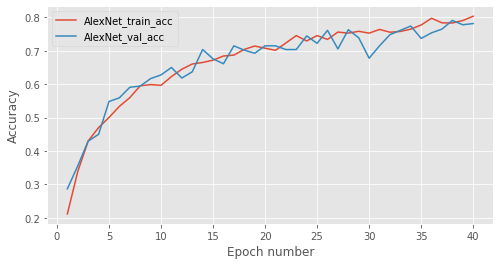

In [18]:
%matplotlib inline
plt.style.use('ggplot')
plot_figure("AlexNet",stats)

In [ ]:
model = AlexNet(num_classes=9, init_weights=False)
save_path = "AlexNet0.6.pth"
model.load_state_dict(torch.load(save_path))
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=2048, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

In [ ]:
""" with torch.no_grad():
    for test_data in test_loader:
        val_images, val_labels = val_data
        outputs = net(val_images.to(device))
        predict_y = torch.max(outputs, dim=1)[1]
        acc += (predict_y == val_labels.to(device)).sum().item()
    val_accurate = acc / val_num
    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(net.state_dict(), save_path)
    print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f' %
            (epoch + 1, running_loss / step, val_accurate)) """